In [1]:
import numpy as np
import pandas as pd
from qiskit import Aer
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.compiler import transpile
from qiskit.extensions import UnitaryGate
from qiskit.opflow import I, X, Y, Z, PauliTrotterEvolution, PrimitiveOp
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram

In [2]:
#import the xyz files and get the atoms in a list
CO_O_Ru = pd.read_csv('CO_O_Ru.csv', sep=',', header=None)
print(CO_O_Ru.values)

[[0.00709277 0.9853895020000001 0.820757602 'Ru']
 [0.34229643200000004 0.9877208909999999 0.821810248 'Ru']
 [0.674113367 0.99165528 0.8218475759999999 'Ru']
 [0.010228858 0.234882321 0.8274280909999999 'Ru']
 [0.34663815299999995 0.236744433 0.822079008 'Ru']
 [0.671452808 0.236251828 0.82131752 'Ru']
 [0.019544913 0.487510946 0.822915153 'Ru']
 [0.34137203899999996 0.488880452 0.822198458 'Ru']
 [0.6650049170000001 0.487131858 0.822945015 'Ru']
 [0.008492572 0.74077902 0.819809474 'Ru']
 [0.336915973 0.7408602540000001 0.8201230279999999 'Ru']
 [0.667275991 0.749135613 0.823172715 'Ru']
 [0.016991096 0.223166012 0.8970109620000001 'C']
 [0.023469247999999998 0.21277234399999997 0.9399566690000001 'O']
 [0.785673003 0.5733024489999999 0.8671262740000001 'O']]


In [3]:
# Brilliant.  Moving on.  
# Get the lattice vectors.
lattice_vectors = pd.read_csv('lattice_vectors.csv', sep=',', header=None)
print(lattice_vectors.values)

[[ 8.31557575  0.          0.        ]
 [ 5.54371717  9.60199979  0.        ]
 [ 0.          0.         26.78963917]]


In [4]:
# Convert to Angstroms instead of fractions of the unit cell vectors.
# An N-atom by 3 matrix times 3x3 lattice matrix yields an Nx3 matrix.
CO_O_Ru_angs=np.matmul(CO_O_Ru.iloc[:, 0:3],lattice_vectors)
CO_O_Ru_angs = np.array(CO_O_Ru_angs)
print(CO_O_Ru_angs)

[[ 5.52170116  9.46170979 21.9878    ]
 [ 8.32203717  9.48409579 22.01600001]
 [11.10309716  9.52187379 22.01700001]
 [ 1.38718     2.25534    22.1665    ]
 [ 4.19494     2.27322    22.02319999]
 [ 6.89323     2.26849    22.0028    ]
 [ 2.86515     4.68108    22.04560002]
 [ 5.54892     4.69423    22.02640002]
 [ 8.23042     4.67744    22.04640001]
 [ 4.17728999  7.11296    21.9624    ]
 [ 6.90877     7.11374    21.9708    ]
 [ 9.70178     7.1932     22.05250001]
 [ 1.37846     2.14284    24.0306    ]
 [ 1.37471001  2.04304    25.1811    ]
 [ 9.71155     5.50485    23.23      ]]


In [5]:
# Slice off unnecessary z-space below.  Convert to atomic units of length.
CO_O_Ru_angs[:, 2] = CO_O_Ru_angs[:, 2] - 20
CO_O_Ru_au = CO_O_Ru_angs/0.52917721067121
print(CO_O_Ru_au)

[[10.43450294 17.88004019  3.7563976 ]
 [15.72637105 17.92234359  3.80968789]
 [20.98181278 17.99373367  3.81157762]
 [ 2.62139028  4.26197491  4.09409165]
 [ 7.9272877   4.29576322  3.82329388]
 [13.02631682  4.28682482  3.78474349]
 [ 5.41434882  8.84595918  3.86562379]
 [10.4859391   8.87080907  3.82934105]
 [15.5532397   8.83908057  3.86713556]
 [ 7.89393404 13.44154633  3.70839854]
 [13.05568317 13.44302034  3.72427224]
 [18.33370714 13.59317797  3.87866289]
 [ 2.60491187  4.04938073  7.61673013]
 [ 2.59782541  3.86078607  9.79086002]
 [18.35216975 10.40265885  6.10381538]]


In [6]:
a1 = 24

In [7]:
CO_O_Ru = np.array(CO_O_Ru)
split = np.linspace(0,a1,16)
#print(split_x)

V_ext_x = []

for i in split:
    #V_ext = 0
    mini_sum = 0
    for j in range(len(CO_O_Ru_angs)):

        distance_x = np.sqrt(np.power(CO_O_Ru_au[j,0] - i,2))


        pseudopotential_x = np.exp(-np.power(distance_x/(1),2))

        #print(pseudopotential)
        element = CO_O_Ru[j,3]
        if element == 'Ru':
            charge = 10#44
        elif element == 'C':
            charge = 6
        elif element == 'O':
            charge = 8
        else:
            charge = 0.0
            
        mini_sum = mini_sum-28*charge*pseudopotential_x #28 is all the valence electrons of the system
        
    V_ext_x.append(mini_sum) 


print(min(V_ext_x))
print(np.sum(V_ext_x)/16)
V_ext_oper = np.diag(V_ext_x)
#V_ext_oper[0,0] = -V_ext
print(V_ext_x)
print(V_ext_oper)

-557.0673764447356
-273.6644796278884
[-0.7427371369483924, -242.6093725740666, -476.1861390872446, -197.5533679267178, -163.20821293795257, -557.0673764447356, -299.58249572526285, -342.9196263232818, -530.8598656630694, -210.6440407634148, -491.3208403136243, -303.2732281388585, -253.06913441001637, -272.09445338383364, -37.46981099327492, -0.030972223912371796]
[[-7.42737137e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.42609373e+02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.76186139e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.

In [8]:
V_nuc_scalar = 0
for k in range(len(CO_O_Ru_au)):
    for l in range(len(CO_O_Ru_au)):
        if k!=l:
            distance = np.sqrt(np.sum(np.power(CO_O_Ru_au[k,:] - CO_O_Ru_au[l,:],2)))
            element1 = CO_O_Ru[k,3]
            if element1 == 'Ru':
                charge1 = 44
            elif element1 == 'C':
                charge1 = 6
            elif element1 == 'O':
                charge1 = 8
            else:
                charge1 = 0.0
            element2 = CO_O_Ru[l,3]
            if element2 == 'Ru':
                charge2 = 44
            elif element2 == 'C':
                charge2 = 6
            elif element2 == 'O':
                charge2 = 8
            else:
                charge2 = 0.0
            pseudopotential = charge1*charge2*np.exp(-np.power(distance/(1),2))
            V_nuc_scalar += charge*pseudopotential/2 #Divided by two because otherwise every pair interaction is counted twice
print(V_nuc_scalar)

3.2907599324517207


In [9]:
# Define the coefficients for the D matrix
d = V_ext_oper

# Construct the D matrix
D = Operator(np.zeros((16, 16)))
i = 0
for P1 in [(I+Z)/2, (I-Z)/2]:
    for P2 in [(I+Z)/2, (I-Z)/2]:
        for P3 in [(I+Z)/2, (I-Z)/2]:
            for P4 in [(I+Z)/2, (I-Z)/2]:
                D = D + d[i][i] * Operator(P1^P2^P3^P4)
                i += 1
                
# Define the given expression
expr = 2 * Operator(I^I^I^I) \
       - Operator(I^I^I^X) \
       - 0.5 * Operator(I^I^X^X) \
       + 0.5 * Operator(I^I^(1j*Y)^(1j*Y)) \
       - 0.25 * Operator((I+X)^X^X^X) \
       - 0.25 * Operator((I+X)^X^(1j*Y)^(1j*Y)) \
       + 0.25 * Operator((I-X)^(1j*Y)^X^(1j*Y)) \
       + 0.25 * Operator((I-X)^(1j*Y)^(1j*Y)^X)

# Compute and print the result
result = -(1/np.power((a1/2),2))*expr + D + (V_nuc_scalar + a1/16)*(I^I^I^I)
result = result/100
# print(result)

In [10]:
np.linalg.eig(result)

(array([ 0.04034066+0.j,  0.04745968+0.j, -0.32692941+0.j, -4.71409268+0.j,
        -2.37832502+0.j, -1.92776498+0.j, -1.5843134 +0.j, -2.67317585+0.j,
        -5.52290506+0.j, -2.4829226 +0.j, -2.98496358+0.j, -4.8654397 +0.j,
        -2.94805623+0.j, -3.38142756+0.j, -2.05867169+0.j, -5.26082995+0.j]),
 array([[ 9.99952416e-01+0.j,  9.75524676e-03+0.j,  3.50724655e-08-0.j,
          4.34256720e-10+0.j, -2.87118743e-05+0.j, -1.35543626e-13+0.j,
         -1.67719260e-17+0.j, -1.93346376e-14+0.j, -8.06105653e-24+0.j,
         -8.88018246e-18+0.j, -4.23126208e-22+0.j,  1.04392449e-28-0.j,
          1.04132677e-26+0.j, -7.02488943e-31+0.j, -1.50064284e-30+0.j,
         -4.36600337e-36+0.j],
        [ 2.87105161e-05+0.j,  2.79269506e-07+0.j,  1.18750871e-12-0.j,
         -2.97308869e-05+0.j,  9.99999999e-01+0.j,  3.84140545e-09-0.j,
          3.92379660e-13-0.j,  4.55354306e-18-0.j,  6.45808620e-19-0.j,
          6.29381464e-21-0.j, -6.90079797e-25+0.j, -3.83555954e-29+0.j,
         -4.479

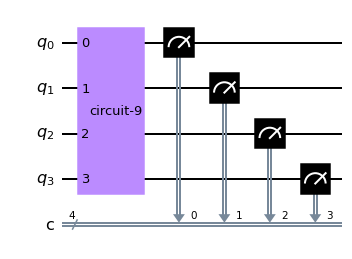

In [11]:
t = Parameter('t')
time_evolution_operator = (t*PrimitiveOp(result)).exp_i()
trotter_exponentiation_circuit = PauliTrotterEvolution().convert(time_evolution_operator)
bound_trotter_exponentiation_circuit = trotter_exponentiation_circuit.bind_parameters({t: 0.1*np.pi})

Full_Trott = bound_trotter_exponentiation_circuit
for i in range(19):
    Full_Trott = Full_Trott @ bound_trotter_exponentiation_circuit

# print(total_time_evolution_circuit)

# Full_Trott = Full_Trott.to_instruction()

qc = QuantumCircuit(4, 4)
qc.append(Full_Trott, [0, 1, 2, 3])
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
qc.draw('mpl')

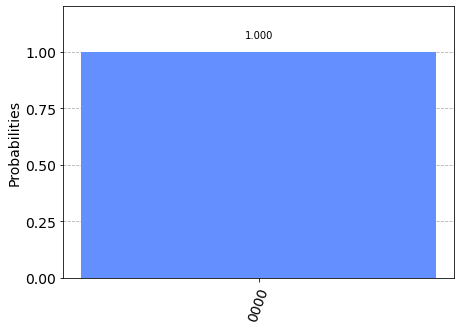

In [12]:
shots = 2000
sim = Aer.get_backend('aer_simulator')
qc_trans = transpile(qc, sim)
counts = sim.run(qc_trans, shots=shots).result().get_counts()
plot_histogram(counts)

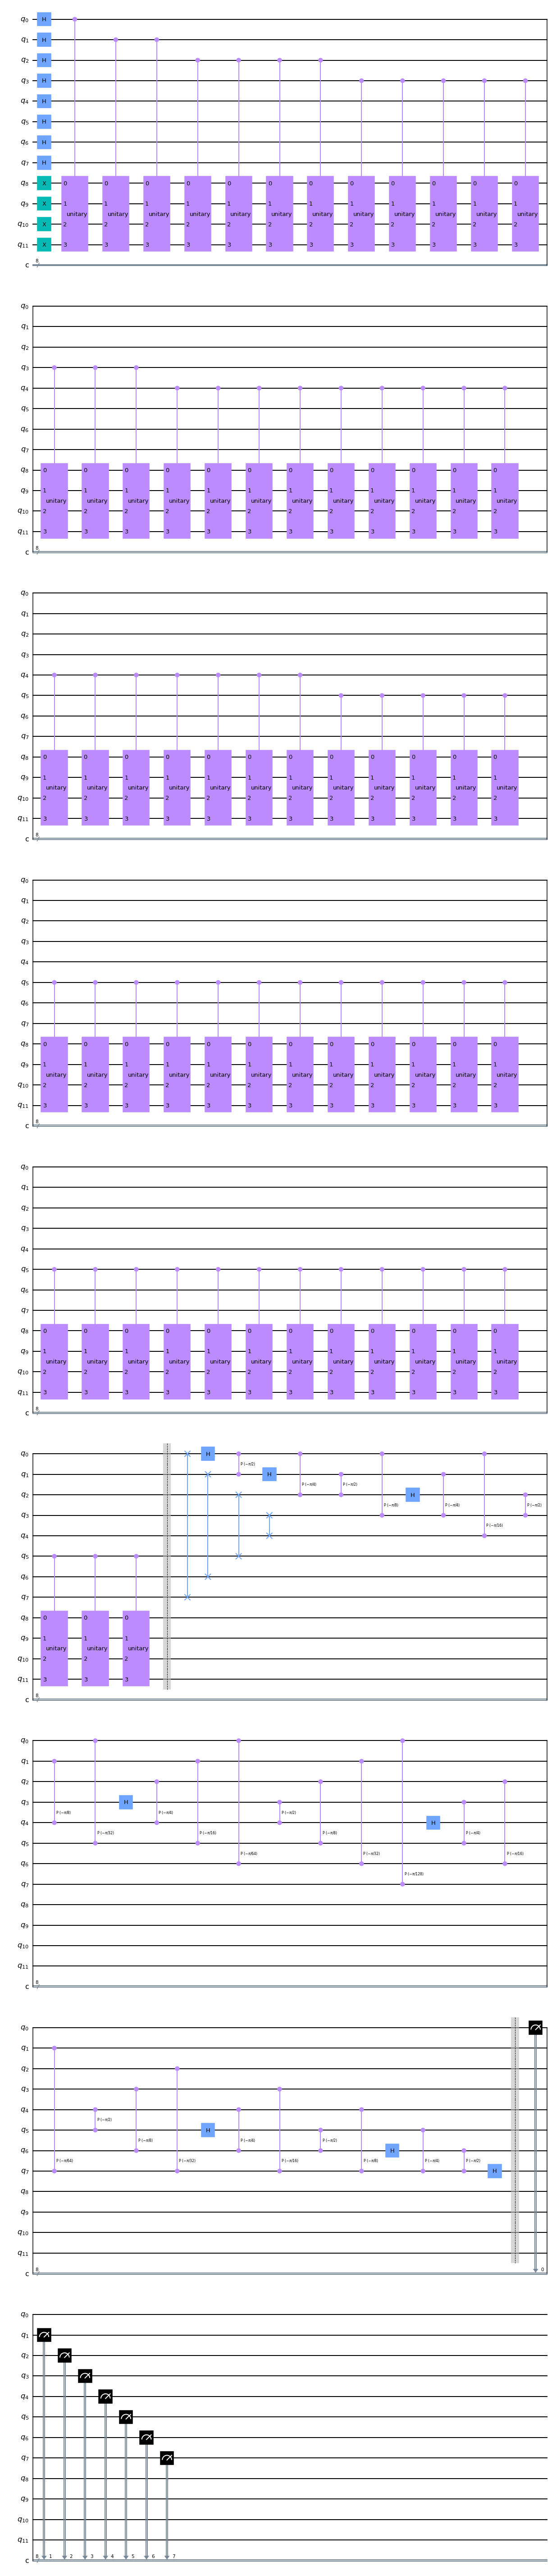

In [13]:
qpe = QuantumCircuit(12, 8)

for qubit in range(8):
    qpe.h(qubit)

qpe.x(8)
qpe.x(9)
qpe.x(10)
qpe.x(11)
    
Controlled_Trott = UnitaryGate(Full_Trott).control(1)

repetitions = 1
for counting_qubit in range(6):
    for i in range(repetitions):
        qpe.append(Controlled_Trott,[counting_qubit,8,9,10,11])
        # qpe.append(Full_Trott,qargs=[8,9,10,11], cargs=[counting_qubit])
    repetitions *= 2
    
def qft_dagger(qc, n):
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
        
qpe.barrier()
qft_dagger(qpe, 8)
qpe.barrier()
for n in range(8):
    qpe.measure(n,n)
    
qpe.draw('mpl')

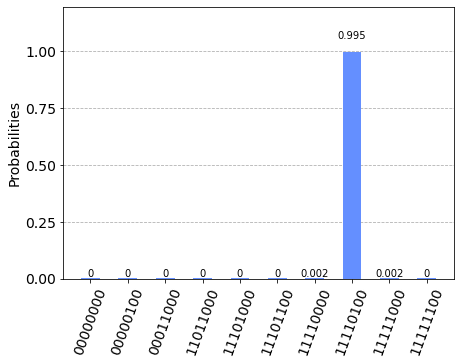

In [14]:
shots = 5000
sim = Aer.get_backend('aer_simulator')
qpe_trans = transpile(qpe, sim)
counts = sim.run(qpe_trans, shots=shots).result().get_counts()
plot_histogram(counts)

In [15]:
print(counts)

{'00000000': 2, '11110100': 4974, '11101000': 1, '00000100': 1, '11110000': 8, '11111000': 9, '11111100': 2, '11011000': 1, '11101100': 1, '00011000': 1}
